In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_all = pd.read_csv('prices-split-adjusted.csv', parse_dates=True)

In [ ]:
# WLTW
data = df_all[['date', 'open', 'close']][df_all['symbol']=='WLTW']
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Находим недостающие даты и добавляем в датафрейм
all_days = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
df_all_days = data.reindex(all_days)
df_filled = df_all_days.fillna({'open': 0, 'close': 0})

# Заполняем недостающие даты предыдущими значениями open и close
df = df_filled.copy()
df['open'].replace(0, pd.NA, inplace=True)
df['close'].replace(0, pd.NA, inplace=True)
df['open'] = df['open'].fillna(method='ffill')
df['close'] = df['close'].fillna(method='ffill')

df['open'].replace(0, pd.NA, inplace=True)
df['close'].replace(0, pd.NA, inplace=True)
df['open'] = df['open'].fillna(method='ffill')
df['close'] = df['close'].fillna(method='ffill')

df['open'].replace(0, pd.NA, inplace=True)
df['close'].replace(0, pd.NA, inplace=True)
df['open'] = df['open'].fillna(method='ffill')
df['close'] = df['close'].fillna(method='ffill')

df = df.reset_index().rename(columns={'index':'date'})


# Объединяем поля open и close
df_open = df[['date', 'open']].copy()
df_open['type'] = 'open'
df_open.rename(columns={'open': 'value'}, inplace=True)

df_close = df[['date', 'close']].copy()
df_close['type'] = 'close'
df_close.rename(columns={'close': 'value'}, inplace=True)

df_combined = pd.concat([df_open, df_close])
df_combined.sort_values(by=['date', 'type'], inplace=True, ascending=[True, False])
df_combined = df_combined.reset_index(drop=True)
df_combined['date'] = pd.to_datetime(df_combined['date'])

df_combined.head()

,date,value,type
0,2016-01-05,123.430000,open
1,2016-01-05,125.839996,close
2,2016-01-06,125.239998,open
3,2016-01-06,119.980003,close
4,2016-01-07,116.379997,open


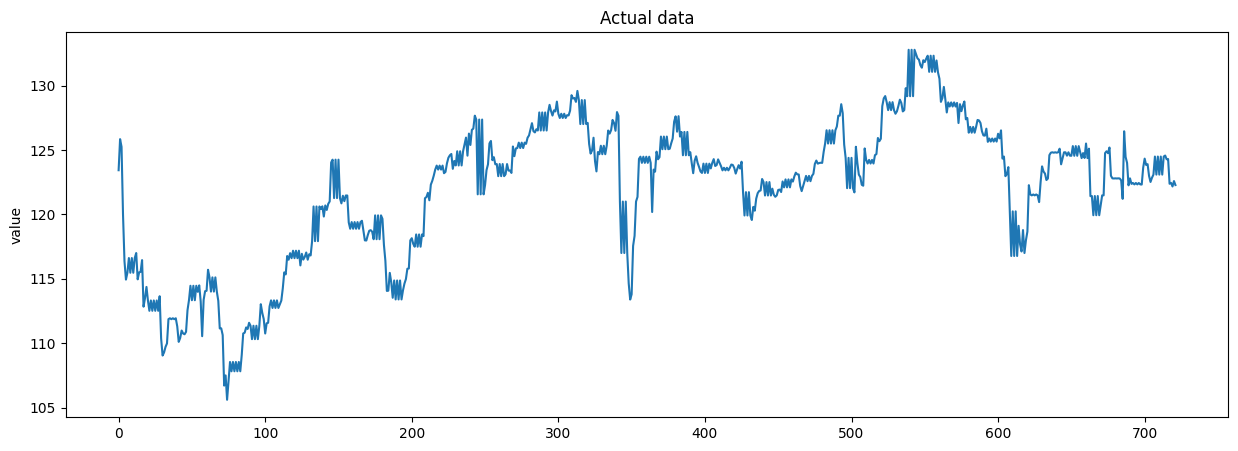

In [ ]:
df_combined = df_combined[['date', 'value']]

plt.figure(figsize=(15, 5))
plt.plot(df_combined['value'])
plt.ylabel('value')
plt.title('Actual data')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_combined[['value']])

In [ ]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 5  # используем последние 5 значений для прогнозирования следующего
X, Y = create_dataset(scaled_data, look_back)

In [ ]:
print('Shape X:', X.shape)

X_dif = X[:-1] - X[1:]
print('Shape X_dif:', X_dif.shape)

X_new = np.hstack([X[:-1], X_dif])
print('Shape X_new:', X_new.shape)

Y = Y[:-1]
print('Shape Y:', Y.shape)

Shape X: (717, 5)
Shape X_dif: (716, 5)
Shape X_new: (716, 10)
Shape Y: (716,)


In [ ]:
# Преобразование в форму, которую ожидает RNN
X = np.reshape(X_new, (X_new.shape[0], X_new.shape[1], 1))
X.shape

(716, 10, 1)

In [ ]:
idx = df_combined[df_combined['date']=='2016-12-01'].index[0] - look_back # тк используем последние 5 значений для прогнозирования следующего

X_train = X[:idx]
X_test = X[idx:]
Y_train = Y[:idx]
Y_test = Y[idx:]

# RNN - Recurrent Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()
# Входной слой
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True))
# Дополнительные слои
model.add(SimpleRNN(50, activation='relu', return_sequences=True))
model.add(SimpleRNN(50, activation='relu'))
# Выходной слой
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test)
pred_inv = scaler.inverse_transform(pred)  # Обратное преобразование, тк ранее делали нормализацию
y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 409ms/step


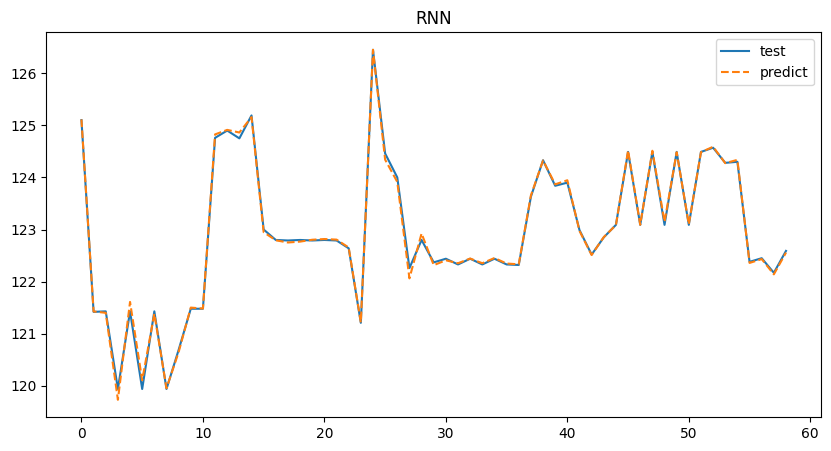

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='test')
plt.plot(pred_inv, label='predict', linestyle='--')
plt.title('RNN')
plt.legend()
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): # средняя абсолютная ошибка в процентах
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_rnn = mean_absolute_percentage_error(y_test_inv, pred_inv)
mae_rnn = mean_absolute_error(y_test_inv, pred_inv)

print(f"MAPE: {mape_rnn}%")
print(f"MAE: {mae_rnn}")

MAPE: 0.031729047250198796%
MAE: 0.03885950702628419


# LSTM - Long Short-Term Memory

In [ ]:
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
model = Sequential()
# Входной слой LSTM
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
# Дополнительные слои
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
# Выходной слой
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model.fit(X_train, Y_train, epochs=100, batch_size=24, validation_data=(X_test, Y_test), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test)
pred_inv = scaler.inverse_transform(pred)
y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


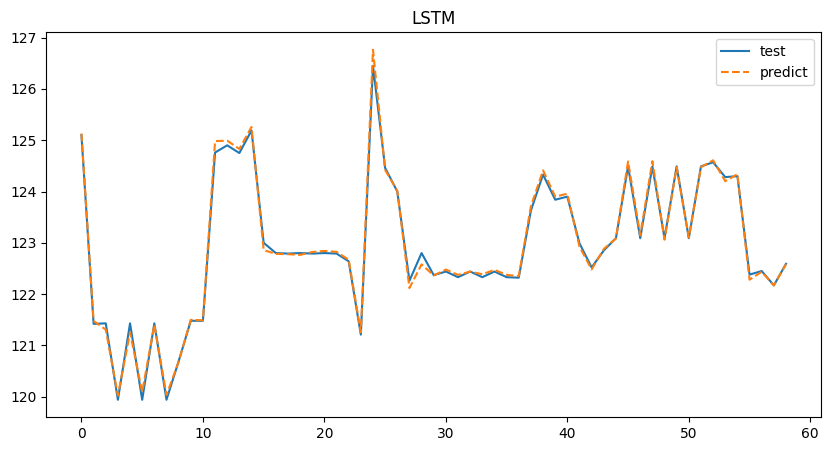

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='test')
plt.plot(pred_inv, label='predict', linestyle='--')
plt.title('LSTM')
plt.legend()
plt.show()

In [ ]:
mape_lstm = mean_absolute_percentage_error(y_test_inv, pred_inv)
mae_lstm = mean_absolute_error(y_test_inv, pred_inv)

print(f"MAPE: {mape_lstm}%")
print(f"MAE: {mae_lstm}")

MAPE: 0.05006817512099316%
MAE: 0.06166350754766948


# GRU - Gated Recurrent Unit

In [ ]:
from tensorflow.keras.layers import GRU, Dense

In [ ]:
model = Sequential()
# Входной слой GRU
model.add(GRU(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
# Дополнительные слои
model.add(GRU(50, return_sequences=True))
model.add(GRU(50))
# Выходной слой
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test))

In [ ]:
pred = model.predict(X_test)
pred_inv = scaler.inverse_transform(pred)
y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


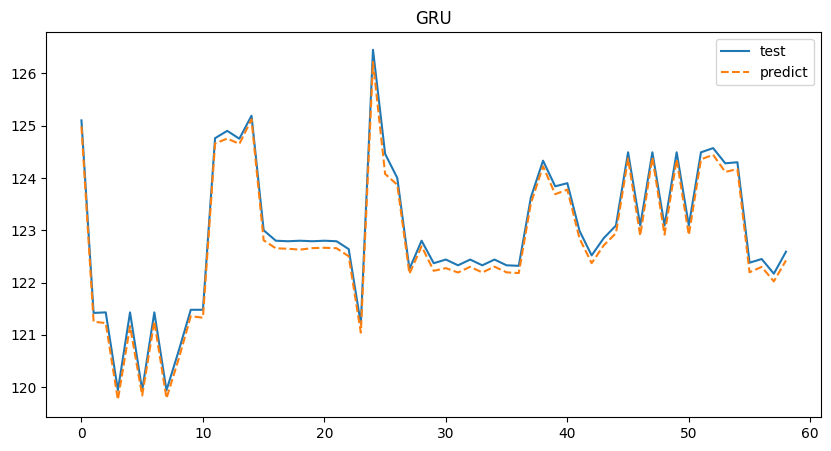

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='test')
plt.plot(pred_inv, label='predict', linestyle='--')
plt.title('GRU')
plt.legend()
plt.show()

In [ ]:
mape_gru = mean_absolute_percentage_error(y_test_inv, pred_inv)
mae_gru = mean_absolute_error(y_test_inv, pred_inv)

print(f"MAPE: {mape_gru}%")
print(f"MAE: {mae_gru}")

MAPE: 0.12142569585368729%
MAE: 0.1492212868197194


# Total

In [ ]:
models = {
    'Model': ['RNN', 'LSTM', 'GRU'],
    'MAE': [mae_rnn, mae_lstm, mae_gru],
    'MAPE': [mape_rnn, mape_lstm, mape_gru]
}

df_models = pd.DataFrame(models)
df_models.head()

,Model,MAE,MAPE
0,RNN,0.038860,0.031729
1,LSTM,0.061664,0.050068
2,GRU,0.149221,0.121426
